# Multiprocessing Behaviour

FLASC's branch detection step and HDBSCAN\*'s core distance computation can 
run in parallel. Due to the memory bound nature of the implementation and the 
overhead + copy costs of `joblib`'s `loky` multiprocess backend, running 
multiple processes is only beneficial for larger datasets. 

This notebook investigates at which sizes multiprocessing becomes beneficial
to find a good default behaviour. Some parts of FLASC are re-implemented
here to investigate the branch-detection step and core-distance step on their
own. Unlike HDBSCAN\*, FLASC will respect the specified `num_jobs` parameter
making it very easy to override the default behaviour.

#### Setup
This cell loads the libraries required to run this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm import trange
from sklearn.utils import shuffle
from joblib.externals.loky import get_reusable_executor

from flasc import FLASC

import seaborn as sns
import matplotlib.pyplot as plt
from _plotting import *
%matplotlib inline
palette = configure_matplotlib()

## Datasets

The same dataset generation procedure is used as for the Computational Cost 
comparison. Clusters are generated using a varying number of random walks starting
from the same position. Multiple clusters are positioned at uniform random positions
sampled from a space that fits 5 times the specified number of clusters. These 
datasets result in non-trivially structured data, which should provide a more useful 
description of FLASC's multi-processing behaviour.

In [2]:
def generate_cluster(
    n_dims=2, n_walks=5, walk_length=50, std_step=0.1
):
    """Generates a cluster by repeating a random walk from (0,0)."""
    # The possible directions
    vectors = np.eye(n_dims)
    # Output collection
    points = []
    # Sample random walks
    for r in range(n_walks):
        directions = np.random.choice(np.arange(n_dims), walk_length)
        lengths = np.random.normal(0, std_step, (walk_length, 1))
        steps = vectors[directions] * lengths
        pts = np.cumsum(steps, axis=0)
        points.append(pts)
    # Add noise
    points = np.concatenate(points)
    return points

def generate_clusters(n_clusters=2, n_dims=2, min_dist=1, n_walks=5):
    # Uniform random samples within volume spaced to fit 2*n_clusters
    extra_spacing_factor = 5
    volume = n_clusters * (min_dist**n_dims)
    length = np.power(extra_spacing_factor * volume, 1./n_dims)
    coords = np.random.uniform(high=length, size=(n_clusters, n_dims))

    # Perform random walks at each coord
    points = np.concatenate([
        generate_cluster(n_dims=n_dims, n_walks=n_walks) + coord
        for coord in coords
    ])
    # Create labels and return
    y = np.repeat(np.arange(n_clusters), 50*n_walks)
    return shuffle(points, y)

We generated 5 data sets for each combination of:
- Number of dimensions
- Number of clusters
- Number of walks per cluster

The cluster radius values, which indicate the 95 percentile distance 
from a cluster's centor to its points, are copied from the 
Computational Cost comparison notebook.

In [3]:
repeats = list(range(5))
num_dims = [2, 8, 16]
cluster_radius = [0.95555435, 0.80832393, 0.7837516]
num_clusters = np.round(np.exp(np.linspace(np.log(2), np.log(800), 10)))
num_walks = np.asarray([5, 10, 20])

params = pd.DataFrame([ 
    (r, ds[0], ds[1], c, w, c * w * 50) 
    for r, ds, c, w in itertools.product(
        repeats,
        zip(num_dims, cluster_radius),
        num_clusters,
        num_walks
    ) if c * w * 50 <= 200000
], columns=['repeat','num_dims', 'min_dist', 'num_clusters', 'num_walks', 'num_points'])
params['X'], params['y'] = zip(*[
    generate_clusters(
        n_dims=int(params.num_dims[i]),
        min_dist=float(params.min_dist[i]),
        n_clusters=int(params.num_clusters[i]),
        n_walks=int(params.num_walks[i])
    ) 
    for i in trange(params.shape[0])
])
params.to_pickle('./data/generated/threading_comparison_datasets.pickle')

## Core distances

The first step that can benefit from multiprocessing is finding the point's 
core distances and neighbours. In the cell below, we extracted this steps 
implementation from the main FLASC function to analyze its run time separately
from the other steps. (cell hidden in docs)

In [5]:
from joblib.memory import Memory
from joblib.parallel import Parallel
from flasc._flasc import SequentialPool
from flasc._hdbscan import (
    _hdbscan_space_tree_linkage,
    _hdbscan_space_tree,
    _hdbscan_space_tree_core_dists_prims
)

def _hdbscan_linkage(
    X,
    num_jobs=1,
    run_override=False,
):
    """Only the HDBSCAN single linkage part of FLASC."""
    min_samples = 10
    memory = Memory(None, verbose=0)
    if num_jobs > 1:
        thread_pool = Parallel(n_jobs=num_jobs, max_nbytes=None)
    else:
        thread_pool = SequentialPool()

    # - Perform clustering
    # -- Compute single linkage hierarchy
    # Declare variables as None
    space_tree = None
    single_linkage_tree = None
    min_spanning_tree = None
    core_distances = None
    neighbours = None

    # Fill values depending on the cases
    space_tree = memory.cache(_hdbscan_space_tree)(
        X, 
        metric='minkowski',
        p=2,
    )
    if run_override:
        (core_distances, neighbours) = memory.cache(
            _hdbscan_space_tree_core_dists_prims, ignore=["thread_pool"]
        )(
            space_tree,
            min_samples=min_samples,
            thread_pool=thread_pool
        )
    else:
        (
            single_linkage_tree,
            min_spanning_tree,
            core_distances,
            neighbours,
        ) = memory.cache(_hdbscan_space_tree_linkage, ignore=["thread_pool"])(
            space_tree,
            min_samples=min_samples,
            metric='minkowski',
            p=2,
            thread_pool=thread_pool,
        )
    return space_tree, single_linkage_tree, min_spanning_tree, core_distances, neighbours

In addition to the dataset parameters, we vary whether clusters are overridden in
this parameter sweep, because with overriden clusters only part of the HDBSCAN\* 
algorithm is evaluated.

In [6]:
# Parameter values to compare
num_jobs = [1, 4]
override_clusters = [True, False]

# Create single data frame with combinations
sweep = pd.DataFrame([
        (d, c, w, c * w * 50, j, o) 
        for d, c, w, j, o in itertools.product(
            num_dims,
            num_clusters,
            num_walks,
            num_jobs,
            override_clusters
        ) if c * w * 50 <= 200000
    ],
    columns=[
        'num_dims', 'num_clusters', 'num_walks', 'num_points',
        'num_jobs', 'override_clusters'
    ]
)
id_vars = sweep.columns.to_list()

To make sure the multi-processing pools are not reused, we force a shutdown
before calling the timed function. Essentially, this assumes a cold-run where
the threading pool is not initialized yet.

In [7]:
def measure_setting(p):
    """Computes the run times of the given setting"""
    num_repeats = len(repeats)
    times = np.nan * np.ones(num_repeats, dtype=np.double)
        
    # Evaluate num_repeat times
    for i in range(num_repeats):
        # Extract the dataset
        param_i = params[
            (params.num_dims == p.num_dims) &
            (params.num_clusters == p.num_clusters) &
            (params.num_walks == p.num_walks) &
            (params.repeat == i)
        ].index[0]        
        X = params.loc[param_i, 'X']

        # Clean up processing backend
        get_reusable_executor().shutdown(wait=True)
        
        # Run the fit
        start = time.perf_counter()
        _hdbscan_linkage(X, num_jobs=p.num_jobs, run_override=p.override_clusters)
        end = time.perf_counter()

        # Store run time and  num clusters
        times[i] = end - start
    return times

The cell below actually runs the parameter sweep in about 2 hours and 40 minutes.

In [8]:
sweep['run_times'] = [ measure_setting(sweep.iloc[i]) for i in trange(sweep.shape[0]) ]
sweep.to_pickle('./data/generated/thread_scaling_core_dists.pickle')

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [2:40:05<00:00, 32.02s/it]


### Results

In the cells below, we try to find out at which data-set sizes multi-processing
becomes beneficial. First, we load the data files, so it is possible to recreate
the figures without running the entire parameter sweep.

In [9]:
params = pd.read_pickle('./data/generated/threading_comparison_datasets.pickle')
sweep = pd.read_pickle('./data/generated/thread_scaling_core_dists.pickle')
repeats = np.arange(len(sweep.run_times[0]))
sweep['repeats'] = [repeats for _ in range(sweep.shape[0])]
sweep = sweep.explode(['run_times', 'repeats'])

Then, we compute the speedup between 1 job and 4 jobs for all datasets.

In [ ]:
pivotted = pd.pivot(sweep, 
         index=[
            'num_dims','num_clusters', 'num_walks','num_points', 
            'override_clusters', 'repeats'
        ],
         columns='num_jobs',
         values='run_times'
)
one_job = pivotted[1].to_numpy()[None].T
multi_jobs = pivotted.iloc[:, 1:]
speedup = (one_job / multi_jobs).reset_index()
speedup = speedup.rename(columns={
    'repeat': 'Repeat',
    'num_dims': 'Num dimensions',
    'num_clusters': 'Num clusters',
    'num_walks': 'Num walks',
    'num_points': 'Num points',
    'override_clusters': 'Override clusters',
    'num_detected_clusters': 'Num detected clusters', 
    'num_jobs': 'Num jobs',
    4: 'Speedup'
})

Now, we can plot the average speedup for the different data-set and cluster sizes:

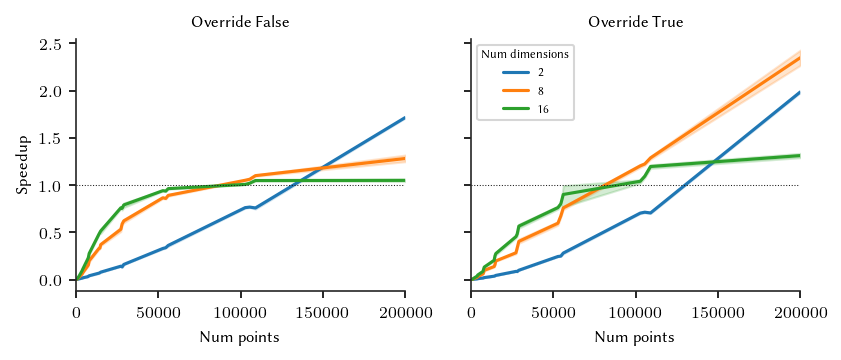

In [33]:
g = sns.FacetGrid(
    speedup,
    col='Override clusters', 
    col_order=[False, True],
)
g.map_dataframe(
    sns.lineplot, 
    x='Num points',
    y='Speedup', 
    hue='Num dimensions',
    palette='tab10'
)
for a in plt.gcf().axes:
    a.plot([0, 200000], [1, 1], 'k:', linewidth=0.5)
    a.set_xlim([0, 200000])
plt.sca(a)
l = plt.legend(title='Num dimensions')
adjust_legend_subtitles(l)
g.set_titles('Override {col_name}')
size_fig(1, aspect=0.618*2/3)
# plt.xscale('log')
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

For these datasets, HDBSCAN\*'s threading limit of +/- 16.000
points is too low. Benefits only start to happend from 50.000
points. For our implementation, we use 125.000 points as conservative
threshold, ensuring no slow-downs occur on 2-dimensional datasets.

The raw numbers:

In [31]:
speedup.groupby(by=[
    'Num clusters', 'Override clusters', 'Num dimensions'
]).Speedup.mean().reset_index().pivot(
    index=['Override clusters', 'Num dimensions'],
    values='Speedup',
    columns='Num clusters'
)

Num clusters                         2.0       4.0       8.0       15.0   \
Override clusters Num dimensions                                           
False             2               0.005177  0.010299  0.022059  0.043019   
                  8               0.015312  0.033583  0.098570  0.195107   
                  16              0.024017  0.055282  0.136907  0.281519   
True              2               0.002616  0.005449  0.011458  0.023468   
                  8               0.007089  0.016132  0.046569  0.097261   
                  16              0.010657  0.025276  0.063608  0.139045   

Num clusters                         29.0      56.0      109.0     211.0  \
Override clusters Num dimensions                                           
False             2               0.088026  0.187841  0.412534  0.548403   
                  8               0.367741  0.603581  0.830696  0.964007   
                  16              0.503949  0.733526  0.915181  0.980591   
True              2               0.051625  0.133886  0.346752  0.478879   
                  8               0.208068  0.410467  0.748709  0.910315   
                  16              0.300975  0.529191  0.817763  0.928171   

Num clusters                         411.0     800.0  
Override clusters Num dimensions                      
False             2               0.761539  1.715687  
                  8               1.051215  1.281790  
                  16              1.007645  1.050434  
True              2               0.703685  1.986652  
                  8               1.203641  2.349060  
                  16              1.040766  1.312453

## Branch Detection

The branch detection step can be performed in parallel for each cluster separately.
Here we analyze whether that has a benefit separately from the other steps.
The functions below implements all FLASC steps that occur before the branch
detection step and the branch detection step on its own. Joblib's Memory 
caching is used to speed up the parts that are not measured. This requires roughly
20Gb free disk space, which is cleaned up when the sweep completes. (code cell
hiddin in docs)

In [5]:
import tempfile
from joblib.parallel import Parallel
from joblib.memory import Memory

tempdir = tempfile.TemporaryDirectory()
memory = Memory(tempdir.name, verbose=0)

In [6]:
from flasc._flasc_branches import (
    _extract_cluster_points,
    _extract_cluster_msts,
)
from flasc._flasc_threaded import (
    _compute_branch_linkage,
    _compute_branch_segmentation,
    _compute_msts_in_cluster_generic,
    _compute_msts_in_cluster_space_tree,
)
from flasc._hdbscan import (
    _hdbscan_generic_reachability,
    _hdbscan_generic_linkage,
    _hdbscan_extract_clusters,
    _hdbscan_space_tree_linkage,
    _hdbscan_space_tree,
    _hdbscan_space_tree_core_dists_prims
)
from flasc._flasc import SequentialPool

def _flasc_clusters(i, run_generic=False, run_override=False):
    """All FLASC steps before the branch-detection step"""
    min_samples = 10
    min_cluster_size = 100
    allow_single_cluster = True
    thread_pool = SequentialPool()

    # Extract the dataset  
    X = params.loc[i, 'X']
    y = params.loc[i, 'y'].astype(np.intp)

    space_tree = None  # not used with generic
    reachability = None  # not used with space tree
    single_linkage_tree = None  # not used with override
    min_spanning_tree = None  # not used with override
    core_distances = None
    neighbours = None  # not used with branch_detection_method != 'core'

    # Fill values depending on the cases
    if run_generic:
        if run_override:
            (reachability, core_distances, neighbours) = \
                _hdbscan_generic_reachability(
                    X, metric='minkowski', p=2
                )
        else:
            (
                single_linkage_tree,
                min_spanning_tree,
                reachability,
                core_distances,
                neighbours,
            ) = _hdbscan_generic_linkage(
                X, metric='minkowski', p=2
            )
    else:
        space_tree = _hdbscan_space_tree(
            X, metric='minkowski', p=2
        )
        if run_override:
            (core_distances, neighbours) = \
                _hdbscan_space_tree_core_dists_prims(
                    space_tree, min_samples=min_samples, thread_pool=thread_pool
                )
        else:
            (
                single_linkage_tree,
                min_spanning_tree,
                core_distances,
                neighbours,
            ) =  _hdbscan_space_tree_linkage(
                space_tree,
                min_samples=min_samples,
                metric = 'minkowski', p=2,
                thread_pool=thread_pool
            )

    # -- Perform cluster segmentation
    # Declare variables as None
    cluster_labels = y if run_override else None
    cluster_probabilities = np.ones(X.shape[0])
    cluster_persistence = None
    condensed_tree = None

    # Fill values depending on the cases
    if not run_override:
        (
            cluster_labels,
            cluster_probabilities,
            cluster_persistence,
            condensed_tree,
        ) = _hdbscan_extract_clusters(
            single_linkage_tree,
            min_cluster_size=min_cluster_size,
            allow_single_cluster=allow_single_cluster
        )

    # - Detect branches
    # -- List the points in each cluster
    if run_override:
        num_clusters = len(np.unique(cluster_labels)) - int(
            -1 in cluster_labels
        )
    else:
        num_clusters = len(cluster_persistence)
    cluster_points = _extract_cluster_points(
        cluster_labels, num_clusters
    )

    return (
        space_tree, reachability, min_spanning_tree, core_distances, neighbours,
        cluster_labels, cluster_probabilities, num_clusters, cluster_points
    )

def _flasc_branches(
    space_tree, reachability, min_spanning_tree, core_distances, neighbours, 
    cluster_labels, cluster_probabilities, num_clusters, cluster_points,
    num_jobs=4,
    run_generic=False,
    run_override=False,
    run_core=False
):
    """The branch detection step"""
    # Construct thread pool and empty memory
    memory = Memory(None, verbose=0)
    min_branch_size = 20
    if num_jobs > 1:
        thread_pool = Parallel(n_jobs=num_jobs, max_nbytes=None)
    else:
        thread_pool = SequentialPool()

    # -- Extract MST
    if not run_override:
        cluster_spanning_trees = memory.cache(_extract_cluster_msts)(
            min_spanning_tree, cluster_labels, num_clusters
        )
    elif run_generic:
        cluster_spanning_trees = memory.cache(
            _compute_msts_in_cluster_generic, ignore=["thread_pool"]
        )(reachability, cluster_points, thread_pool)
    else:
        cluster_spanning_trees = memory.cache(
            _compute_msts_in_cluster_space_tree, ignore=["thread_pool"]
        )(
            space_tree,
            core_distances,
            cluster_points,
            thread_pool,
            metric='minkowski', 
            p=2
        )

    # -- Compute branch single-linkage
    (
        cluster_centralities,
        cluster_linkage_trees,
        cluster_approximation_graphs,
    ) = memory.cache(_compute_branch_linkage, ignore=["thread_pool"])(
        space_tree,  # None if run_generic
        reachability,  # None if not run_generic
        core_distances,
        neighbours,  # None if not run_core
        cluster_probabilities,
        cluster_spanning_trees,
        cluster_points,
        thread_pool,
        metric='minkowski',
        run_core=run_core,
        run_generic=run_generic,
        run_override=run_override,
        p=2
    )

    # -- Extract branch segmentation
    (
        branch_labels,
        branch_probabilities,
        branch_persistences,
        cluster_condensed_trees,
    ) = memory.cache(_compute_branch_segmentation, ignore=["thread_pool"])(
        cluster_linkage_trees,
        thread_pool,
        min_branch_size=min_branch_size,
    )
    return (
        branch_labels, branch_probabilities, branch_persistences, 
        cluster_condensed_trees, cluster_approximation_graphs, cluster_linkage_trees,
        cluster_centralities
    )

FLASC's main parameters are varied so we can find a good threshold for each
variant of the algorithm:
- branch detection method, 
- cluster override

FLASC's generic algorithm variant, which computes the full distance matrix is
not tested here, as no speedups were observed with that variant previously.

In [7]:
# Parameter values to compare
branch_detection_method = ['core', 'full']
override_clusters = [True, False]
num_jobs = [1, 4]

# Create single data frame with combinations
sweep = pd.DataFrame([
        (d, c, w, c * w * 50, j, b, o) 
        for d, c, w, j, b, o in itertools.product(
            num_dims,
            num_clusters,
            num_walks,
            num_jobs,
            branch_detection_method,
            override_clusters
        ) if c * w * 50 <= 200000
    ],
    columns=[
        'num_dims', 'num_clusters', 'num_walks', 'num_points',
        'num_jobs', 'branch_detection_method', 'override_clusters'
    ]
)
id_vars = sweep.columns.to_list()

As before, the `loky` backend is shutdown between runs to make sure no
caching benefits influence the comparison.

In [8]:
def measure_setting(p):
    """Computes the run times of the given setting"""
    num_repeats = len(repeats)
    times = np.nan * np.ones(num_repeats, dtype=np.double)
        
    # Evaluate num_repeat times
    for i in range(num_repeats):
        # Find data-set index
        param_i = params[
            (params.num_dims == p.num_dims) &
            (params.num_clusters == p.num_clusters) &
            (params.num_walks == p.num_walks) &
            (params.repeat == i)
        ].index[0]      

        # Compute clusters and points
        run_generic = False
        run_override = p.override_clusters
        run_core = p.branch_detection_method == 'core'
        preparation = memory.cache(_flasc_clusters)(
            param_i, run_generic=run_generic, run_override=run_override
        )

        # Clean up processing backend
        get_reusable_executor().shutdown(wait=True)

        # Run the branch detection step
        start = time.perf_counter()
        _flasc_branches(
            *preparation, 
            run_generic=run_generic, 
            run_override=run_override, 
            run_core=run_core,
            num_jobs=p.num_jobs
        )
        end = time.perf_counter()
        
        # Store run time and  num clusters
        times[i] = end - start
    return times

The cell below runs the actual sweep, which takes about 4 hours.

In [9]:
sweep['run_times'] = [ measure_setting(sweep.iloc[i]) for i in trange(sweep.shape[0]) ]
sweep.to_pickle('./data/generated/thread_scaling_branches.pickle')
tempdir.cleanup()

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [4:01:28<00:00, 24.15s/it]


### Results

In this section we plot the results from the branch-detection sweep. The data-files
are read in again so that the figures can be re-created without running the sweep.

In [44]:
params = pd.read_pickle('./data/generated/threading_comparison_datasets.pickle')
sweep = pd.read_pickle('./data/generated/thread_scaling_branches.pickle')
repeats = np.arange(len(sweep.run_times[0]))
sweep['repeats'] = [repeats for _ in range(sweep.shape[0])]
sweep = sweep.explode(['run_times', 'repeats'])

The speedup from 1 to 4 jobs is computed:

In [ ]:
pivotted = pd.pivot(sweep, 
         index=[
            'num_dims', 'num_clusters', 'num_walks', 'num_points',
            'branch_detection_method', 'override_clusters', 'repeats'
        ],
         columns='num_jobs',
         values='run_times'
)
one_job = pivotted[1].to_numpy()[None].T
multi_jobs = pivotted.iloc[:, 1:]
speedup = (one_job / multi_jobs).reset_index()
speedup = speedup.rename(columns={
    'repeat': 'Repeat',
    'num_dims': 'Num dimensions',
    'num_clusters': 'Num clusters',
    'num_walks': 'Num walks',
    'num_points': 'Num points',
    'branch_detection_method': 'Branch detection',
    'override_clusters': 'Override clusters',
    'num_jobs': 'Num jobs',
    4: 'Speedup'
})

The figure below shows the speedups for the different FLASC 
parameter combinations and dataset dimensions. Again, 2D datasets
benefit the least from multiprocessing.

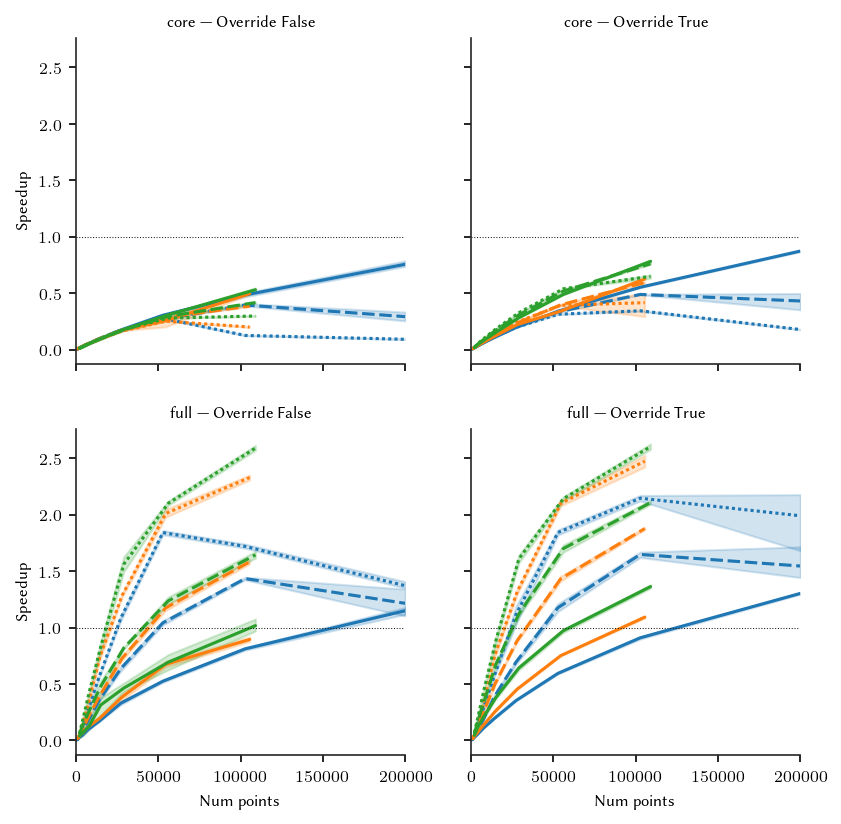

In [43]:
g = sns.FacetGrid(
    speedup, 
    row='Branch detection', 
    col="Override clusters",
    row_order=['core', 'full'], 
    col_order=[False, True]
)
g.map_dataframe(
    sns.lineplot, 
    x='Num points',
    y='Speedup', 
    hue='Num walks',
    style='Num dimensions',
    palette='tab10'
)
for a in plt.gcf().axes:
    a.plot([0, 200000], [1, 1], 'k:', linewidth=0.5)
    a.set_xlim([0, 200000])
g.set_titles('{row_name} | Override {col_name}')
# g.set(ylim=(0, 250))
# plt.xscale('log')
size_fig(1, 1)
plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.savefig('./images/threading_best_size.png')
plt.show()

For the core branch detection approach, spinning up multiple processes is not worth it (at this `min_samples` value), regardless of dataset size. Only when the pool is re-used from the core distances step, could there be a benefit, but even that appears unlikely. For the full branch detection method, multiprocessing becomes beneficial from around 150.000 data points. However, because a threadpool is created for the core distance step at 125.000 points, re-using that pool is likely beneficial already. So, in the final implementation, we disable the
thread pool for the branch detection step when the core detection method or generic variant of the algorithm is used. Otherwise, the pool from the core distances step is re-used. 

It can be worth enabling multiprocessing manually for datasets with tens of thousands of points if they have more than 2 dimensions.

In [13]:
speedup.groupby(by=[
    'Num clusters', 'Num walks', 'Override clusters', 'Branch detection', 'Num dimensions'
]).Speedup.mean().reset_index().pivot(
    index=['Branch detection', 'Override clusters', 'Num walks', 'Num dimensions'],
    values='Speedup',
    columns='Num clusters'
)

Num clusters                                                    2.0    \
Branch detection Override clusters Num walks Num dimensions             
core             False             5         2               0.003159   
                                             8               0.002931   
                                             16              0.002928   
                                   10        2               0.005429   
                                             8               0.005681   
                                             16              0.005520   
                                   20        2               0.010943   
                                             8               0.011226   
                                             16              0.010768   
                 True              5         2               0.003137   
                                             8               0.003665   
                                             16              0.003711   
                                   10        2               0.006769   
                                             8               0.007501   
                                             16              0.008003   
                                   20        2               0.016858   
                                             8               0.018425   
                                             16              0.020348   
full             False             5         2               0.005859   
                                             8               0.005682   
                                             16              0.006155   
                                   10        2               0.018080   
                                             8               0.014676   
                                             16              0.017140   
                                   20        2               0.039610   
                                             8               0.054310   
                                             16              0.059054   
                 True              5         2               0.005828   
                                             8               0.005980   
                                             16              0.006963   
                                   10        2               0.015712   
                                             8               0.016179   
                                             16              0.019345   
                                   20        2               0.045825   
                                             8               0.054985   
                                             16              0.068774   

Num clusters                                                    4.0    \
Branch detection Override clusters Num walks Num dimensions             
core             False             5         2               0.005944   
                                             8               0.007304   
                                             16              0.007461   
                                   10        2               0.011559   
                                             8               0.013227   
                                             16              0.015637   
                                   20        2               0.021226   
                                             8               0.026767   
                                             16              0.028713   
                 True              5         2               0.008425   
                                             8               0.008627   
                                             16              0.009020   
                                   10        2               0.017592   
                                             8               0.019264   
                                             16          

## Full implementation

Finally, lets check the full FLASC implementation to validate that the default behaviour does not introduce slow-downs.  

In [6]:
# Parameter values to compare
branch_detection_method = ['core', 'full']
override_clusters = [True, False]
enable_threading = [True, False]

# Create single data frame with combinations
sweep = pd.DataFrame([
        (d, c, w, c * w * 50, j, b, o) 
        for d, c, w, j, b, o in itertools.product(
            num_dims,
            num_clusters,
            num_walks,
            enable_threading,
            branch_detection_method,
            override_clusters
        ) if c * w * 50 <= 200000
    ],
    columns=[
        'num_dims', 'num_clusters', 'num_walks', 'num_points',
        'enable_threading', 'branch_detection_method', 'override_clusters'
    ]
)
id_vars = sweep.columns.to_list()

In [7]:
def measure_setting(p):
    """Computes the run times of the given setting"""
    num_repeats = len(repeats)
    times = np.nan * np.ones(num_repeats, dtype=np.double)
        
    # Evaluate num_repeat times
    for i in range(num_repeats):
        # Find data-set index
        param_i = params[
            (params.num_dims == p.num_dims) &
            (params.num_clusters == p.num_clusters) &
            (params.num_walks == p.num_walks) &
            (params.repeat == i)
        ].index[0]
        X = params.X[param_i]
        y = params.y[param_i]

        # Compute clusters and points
        clusterer = FLASC(
            min_samples=10,
            min_cluster_size=100,
            min_branch_size=20,
            allow_single_cluster=True,
            override_cluster_labels=y if p.override_clusters else None,
            branch_detection_method=p.branch_detection_method,
            num_jobs = None if p.enable_threading else 1,
        )
        
        # Clean up processing backend
        get_reusable_executor().shutdown(wait=True)
        
        # Run the branch detection step
        start = time.perf_counter()
        clusterer.fit(X)
        end = time.perf_counter()
        
        # Store run time and  num clusters
        times[i] = end - start
    return times

The sweep below takes roughly 7 hours.

In [8]:
sweep['run_times'] = [ measure_setting(sweep.iloc[i]) for i in trange(sweep.shape[0]) ]
sweep.to_pickle('./data/generated/thread_scaling.pickle')

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [6:50:00<00:00, 41.00s/it]


### Results

In this section we plot the results from the branch-detection sweep. The data-files
are read in again so that the figures can be re-created without running the sweep.

In [9]:
params = pd.read_pickle('./data/generated/threading_comparison_datasets.pickle')
sweep = pd.read_pickle('./data/generated/thread_scaling.pickle')
repeats = np.arange(len(sweep.run_times[0]))
sweep['repeats'] = [repeats for _ in range(sweep.shape[0])]
sweep = sweep.explode(['run_times', 'repeats'])

The speed up is computed:

In [ ]:
pivotted = pd.pivot(sweep, 
         index=[
            'num_dims', 'num_clusters', 'num_walks', 'num_points',
            'branch_detection_method', 'override_clusters', 'repeats'
        ],
         columns='enable_threading',
         values='run_times'
)
one_job = pivotted[False].to_numpy()
multi_jobs = pivotted[True]
speedup = (one_job / multi_jobs).reset_index()
speedup = speedup.rename(columns={
    'repeat': 'Repeat',
    'num_dims': 'Num dimensions',
    'num_clusters': 'Num clusters',
    'num_walks': 'Num walks',
    'num_points': 'Num points',
    'branch_detection_method': 'Branch detection',
    'override_clusters': 'Override clusters',
    True: 'Speedup'
})

The figures below show the speedup for the different parameter combinations:

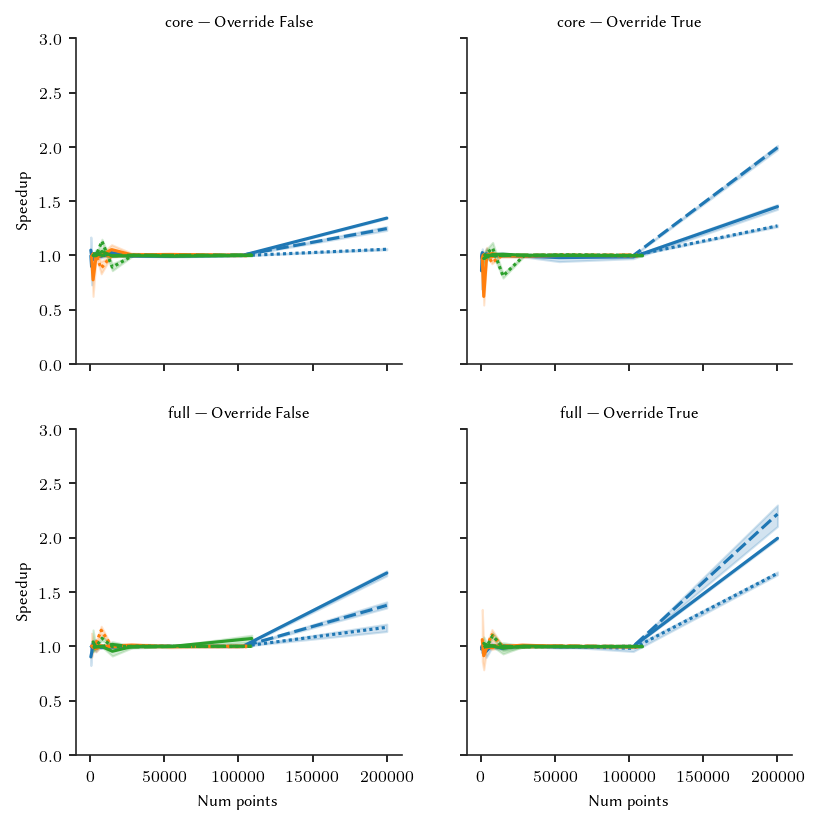

In [13]:
g = sns.FacetGrid(
    speedup, 
    row='Branch detection', 
    col="Override clusters",
    row_order=['core', 'full'], 
    col_order=[False, True]
)
g.map_dataframe(
    sns.lineplot, 
    x='Num points',
    y='Speedup', 
    hue='Num walks',
    style='Num dimensions',
    palette='tab10'
)
g.set_titles('{row_name} | Override {col_name}')
g.set(ylim=(0, 3))
# plt.xscale('log')
size_fig(1, 1)
plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.savefig('./images/threading_best_size.png')
plt.show()

This is a reasonable result. There is a noticable speedup for large datasets. For smaller datasets with more dimensions, there is no slowdown. Manually enabling multi-processing would result in more speedups. There is some variation in speedup at smaller datasets, for with no multi-processing occurs. This is likely due to background tasks or other interference.

The raw values are shown below:

In [12]:
speedup.groupby(by=[
    'Num clusters', 'Num walks', 'Override clusters', 'Branch detection', 'Num dimensions'
]).Speedup.mean().reset_index().pivot(
    index=['Branch detection', 'Override clusters', 'Num walks', 'Num dimensions'],
    values='Speedup',
    columns='Num clusters'
)

Num clusters                                                    2.0    \
Branch detection Override clusters Num walks Num dimensions             
core             False             5         2               1.048687   
                                             8               1.002823   
                                             16              1.001668   
                                   10        2               0.994004   
                                             8               0.984689   
                                             16              1.002216   
                                   20        2               0.999919   
                                             8               1.015203   
                                             16              1.001609   
                 True              5         2               0.858018   
                                             8               0.969761   
                                             16              0.982635   
                                   10        2               0.981934   
                                             8               1.008657   
                                             16              0.998010   
                                   20        2               0.971642   
                                             8               0.965328   
                                             16              0.994387   
full             False             5         2               0.902959   
                                             8               0.987607   
                                             16              1.007962   
                                   10        2               1.003720   
                                             8               0.995194   
                                             16              0.992229   
                                   20        2               1.040651   
                                             8               1.002801   
                                             16              0.984919   
                 True              5         2               0.991949   
                                             8               0.996766   
                                             16              0.962467   
                                   10        2               1.062156   
                                             8               1.004948   
                                             16              0.983020   
                                   20        2               1.027089   
                                             8               1.009391   
                                             16              0.991513   

Num clusters                                                    4.0    \
Branch detection Override clusters Num walks Num dimensions             
core             False             5         2               0.998321   
                                             8               0.898074   
                                             16              0.998073   
                                   10        2               0.775257   
                                             8               1.014262   
                                             16              1.000690   
                                   20        2               0.996704   
                                             8               1.015858   
                                             16              1.000310   
                 True              5         2               1.025632   
                                             8               1.016629   
                                             16              1.006680   
                                   10        2               0.622268   
                                             8               0.994673   
                                             16          